In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns
from sklearn import cluster
from ipyparallel import Client
import scipy.cluster.hierarchy as sch
import json
import scipy as sp
import scipy.stats

%matplotlib inline

_RC = Client()
_DVIEW = _RC[:]
print (len(_RC))

26


In [10]:
@_DVIEW.parallel(block=True)
def intersect_to_array(chrom, window=2000, binsize=20):
    import pybedtools as pbt
    from collections import OrderedDict
    import numpy as np
    
    def make_gene_array(bed_intersect_line, window):
        c = str(bed_intersect_line).split('\t')
        window = 2 * window
        a = np.zeros(window)
        if c[6] == '.':
            return c[3], a
        strand = c[5]
        s = int(c[7]) - int(c[1])
        e = int(c[8]) - int(c[1])
        if s < 0:
            s = 0
        if e  >= window:
            e = window - 1
        if strand == "-":
            s = window - s
            e = window - e
            temp = s
            s = e
            e = temp
        a[s:e]+=float(c[10])
        return c[3], a

    def get_binned_array(a, b):
        remainder = len(a) % b
        if remainder > 0:
            binned = a[:-remainder]
        else:
            binned = a.copy()
        binned = binned.reshape(len(a) // b, b).mean(axis=1)
        if remainder > 0:
            return np.append(binned, a[-remainder:].mean())
        return binned
    
    base_dir = '/home/parashar/scratch/quadcomb/data/'
    gencode_tss_loc = base_dir + 'annotation/chrom_wise_gencode_tss'
    qg_dir = base_dir + 'QuadGraphs_bed'
    gencode_tss = pbt.BedTool("%s/%s.bed" % (gencode_tss_loc, chrom)).slop(
                    b=window, genome='hg19')
    qg_bed = pbt.BedTool("%s/%s.bed" % (qg_dir, chrom))
    intersect = gencode_tss.intersect(qg_bed, wao=True)
    gene_arrays = OrderedDict()
    for n,i in enumerate(intersect):
        g, a = make_gene_array(i, window)
        if g not in gene_arrays:
            gene_arrays[g] = get_binned_array(a, binsize)            
        else:
            gene_arrays[g] += get_binned_array(a, binsize)
    return gene_arrays    

In [11]:
chroms = ['chr'+str(x) for x in range(1, 23)] + ['chrX', 'chrY']
gene_arrays = intersect_to_array.map(chroms)

In [ ]:
def deduplicate_matrix(m):
    deduplicated_matrix = []
    last = m[0]
    for i in m[1:]:
        if (i != last).any():
            deduplicated_matrix.append(i)
        last = i[:]
    return np.array(deduplicated_matrix)

def plot_matrix(chrom, m):
    fig_height = max(1, m.shape[0]//2000)
    fig, ax = plt.subplots(1,1, figsize=(3, fig_height))
    sns.heatmap(m, yticklabels=False, xticklabels=False, cbar=True,
                vmin=0, vmax=2.5, cmap='YlGnBu', ax=ax, lw=0)
    ax.set_xticks([0, 50, 100])
    ax.axvline(50, color='Grey', alpha=0.7, ls='--')
    ax.set_xticklabels([-2000, 'TSS', 2000], rotation=30)
    ax.set_title(chrom, fontsize=14)
    fig.tight_layout()
    plt.savefig('./images/tss_g4/%s.png' % chrom, dpi=200)
    plt.show()

In [ ]:
all_values = []
all_transcripts = []
for chrom, ga in zip(chroms, gene_arrays):
    matrix = deduplicate_matrix(np.array(list(ga.values())))
    print (chrom, matrix.shape)
    if chrom == "chr14":
        plot_matrix(chrom, matrix)
    all_values.extend([x for x in matrix])
    all_transcripts.extend(ga.keys())
all_values = np.array(all_values)

In [7]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h

res = []
for i in range(all_values.shape[1]):
    res.append(mean_confidence_interval(all_values[:, i]))
res = np.array(res).T

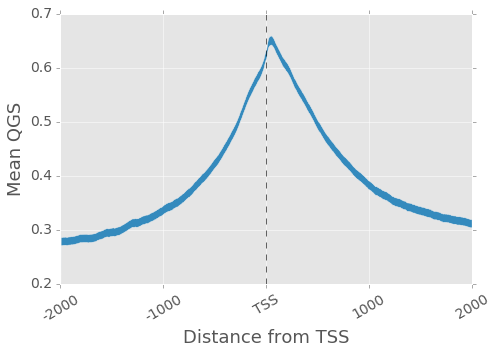

In [8]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(7,5))

f = 3
x = list(range(len(res[0])))
y1 = res[0] - ((res[0]-res[1]) * f)
y2 = res[0] + ((res[2]-res[0]) * f)

ax.axvline(1000, color='k', alpha=0.6, ls='--', label='Mean QGS')
ax.fill_between(x, y1, y2, alpha=1, label='QGS variance')
ax.set_xticklabels([-2000, -1000, 'TSS', 1000, 2000], fontsize=14, rotation=30)
for label in ax.get_yticklabels():
    label.set_fontsize(14)
ax.set_xlabel('Distance from TSS', fontsize=18)
ax.set_ylabel('Mean QGS', fontsize=18)
fig.tight_layout()
plt.savefig('./images/tss_summary.png', dpi=200)
plt.show()

In [16]:
voi = [t for v, t in zip(all_values, all_transcripts) if (v>2.5).any()]
gencode_data = json.load(open('./data/annotation/hg19_gencode.json'))goi = []
for i in voi:
    goi.append(gencode_data[i]['gene_name'].split('.')[0])
goi = list(set(goi))

In [11]:
all_values.shape

(183864, 2000)